In [1]:
import time
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csc_matrix, csr_matrix, dok_matrix
from scipy.optimize import curve_fit

from sgp import KGgraphrnd

%matplotlib inline

## Randomly sample a KG from two CRMs

In [2]:
alpha = 100 # controls the number of entities
beta = 5  # controls the number of relations
sigma_alpha = 0.5
sigma_beta = 0.1
tau_alpha = 1.
tau_beta = 10.
sampled_graph = KGgraphrnd(alpha, beta, sigma_alpha, sigma_beta, tau_alpha, tau_beta)
T = sampled_graph[0]

In [3]:
n_r = len(T); n_e = T[0].shape[0]

### Basic stats:

In [4]:
print('number of relations: %d\nnumber of entities: %d\nnumber of triples %d' % (n_r, n_e, np.sum([t.sum() for t in T])))

number of relations: 48
number of entities: 1527
number of triples 3712


### Number of triples for each relation:

(0, 48)

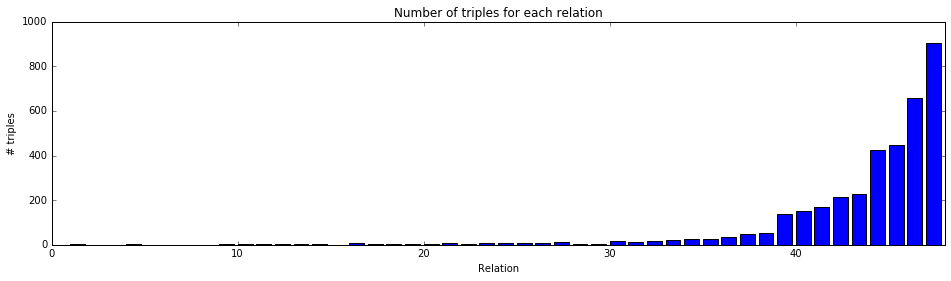

In [5]:
n_triples = [T[i].sum() for i in range(n_r)]
plt.figure(figsize=(16,4))
plt.bar(np.arange(n_r), n_triples)
plt.title('Number of triples for each relation')
plt.xlabel('Relation'); plt.ylabel('# triples')
plt.xlim([0,n_r])

## Computing a growth rate of triples w.r.t. the number of randomly selected entities

In [6]:
def random_entity_triple(T, n_samples = 100):
    n_r = len(T); n_e = T[0].shape[0]
    n_entities = list()
    n_triples = list()

    en_shuffle = np.arange(n_e)
    collapsedT = csc_matrix(T[0])
    for r in range(1, n_r):
        collapsedT += T[r]

    tic = time.time()
    for s in range(n_samples):
        r_samples = np.random.randint(2, n_e)
        np.random.shuffle(en_shuffle)

        cnt = collapsedT[np.ix_(en_shuffle[:r_samples], en_shuffle[:r_samples])].sum()

        n_entities.append(r_samples)
        n_triples.append(cnt)
        
    print('Elpased time', time.time()-tic)    
    return n_entities, n_triples

n_entities, n_triples = random_entity_triple(T, n_samples = 1000)

Elpased time 33.879006147384644


### Fitting a curve with randomly sampled growth 

In [7]:
def func(x, a, b, c):
    return c*x**a + b

popt, pcov = curve_fit(func, n_entities, n_triples)
fitted_t = func(np.arange(n_e), *popt)

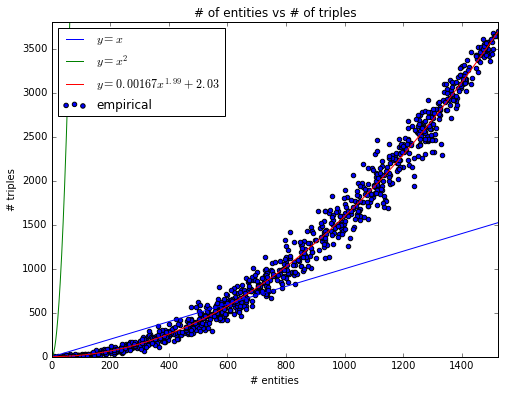

In [8]:
plt.figure(figsize=(8,6))
plt.scatter(n_entities, n_triples, label='empirical')
first_order = [x for x in range(n_e)]
second_order = [x**2 for x in range(n_e)]
plt.plot(first_order, label='$y=x$')
plt.plot(second_order, label='$y=x^2$')
plt.plot(fitted_t, label='$y=%.5f x^{%.2f} + %.2f$' % (popt[2], popt[0], popt[1]))

plt.legend(loc='upper left')
plt.xlim([0, np.max(n_entities)])
plt.ylim([0, np.max(n_triples)+100])
plt.title('# of entities vs # of triples')
plt.xlabel('# entities')
plt.ylabel('# triples')

## Computing a growth rate of triples w.r.t. the number of randomly selected relations

In [9]:
def random_relation_triple(T, n_samples=100):
    n_r = len(T); n_e = T[0].shape[0]
    n_relations = list()
    n_triples = list()
    n_samples = 10000 # repeat counting n_sample times

    shuffled_r = np.arange(n_r)

    tic = time.time()
    for s in range(n_samples):
        r_samples = np.random.randint(1, n_r)
        np.random.shuffle(shuffled_r)

        cnt = 0
        for ri in shuffled_r[:r_samples]:
            cnt += T[ri].nnz

        n_relations.append(r_samples)
        n_triples.append(cnt)
    print('Elpased time', time.time()-tic)
    return n_relations, n_triples

n_relations, n_triples = random_relation_triple(T, n_samples = 10000)

Elpased time 0.5503110885620117


(0, 47)

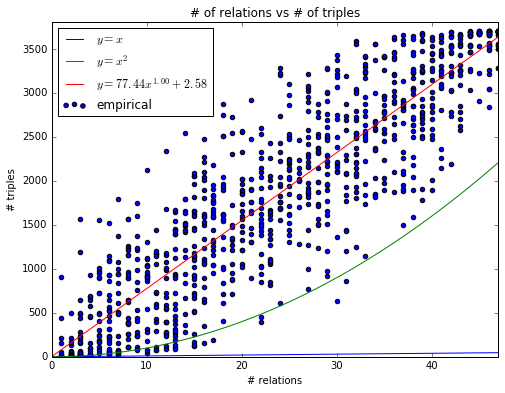

In [10]:
popt, pcov = curve_fit(func, n_relations, n_triples) 
fitted_t = func(np.arange(n_r), *popt) 

plt.figure(figsize=(8,6))
plt.scatter(n_relations[::10], n_triples[::10], label='empirical')
plt.title('# of relations vs # of triples')
plt.xlabel('# relations')
plt.ylabel('# triples')

first_order = [x for x in range(n_r)]
second_order = [x**2 for x in range(n_r)]
plt.plot(first_order, label='$y=x$')
plt.plot(second_order, label='$y=x^2$')
plt.plot(fitted_t, label='$y=%.2f x^{%.2f} + %.2f$' % (popt[2], popt[0], popt[1]))
plt.legend(loc='upper left')
plt.ylim([0, np.max(n_triples)+100])
plt.xlim([0, np.max(n_relations)])

## Number of entity of degree one

Count the entity of nodes of degree one with varying sparsity parameter $\sigma$.

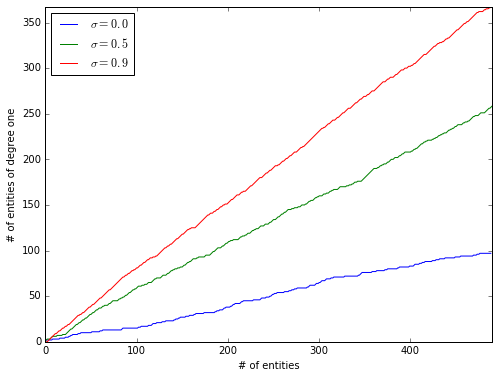

In [11]:
alpha = 100 # controls the number of entities
beta = 5  # controls the number of relations
sigma_alphas = [0.0, 0.5, 0.9]
sigma_beta = 0.1
tau_alpha = 1.
tau_beta = 10.

min_x = 1e10
cumsums = dict()
for sigma_alpha in sigma_alphas:
    sampled_graph = KGgraphrnd(alpha, beta, sigma_alpha, sigma_beta, tau_alpha, tau_beta)
    T = sampled_graph[0]
    n_r = len(T); n_e = T[0].shape[0]
    collapsedT = csc_matrix(T[0])
    for r in range(1, n_r):
        collapsedT += T[r]

    entity_degree = (collapsedT.sum(0) + collapsedT.sum(1).T).tolist()[0]

    e_list = np.arange(n_e)
    np.random.shuffle(e_list)
    one_entity = [entity_degree[ei] == 1 for ei in e_list]
    cumsums[sigma_alpha] = np.cumsum(one_entity)
    if cumsums[sigma_alpha].size < min_x:
        min_x = cumsums[sigma_alpha].size
        

max_y = np.max([cumsums[k][min_x-1] for k in cumsums])
plt.figure(figsize=(8,6))
for sigma_alpha in sigma_alphas:
    plt.plot(cumsums[sigma_alpha], label = '$\sigma = %.1f$' % (sigma_alpha))        
plt.xlabel('# of entities')
plt.ylabel('# of entities of degree one')
plt.xlim([0, min_x])
plt.ylim([0, max_y])
plt.legend(loc='upper left')

# Replicate the same experiments with Freebase dataset

In [12]:
def construct_freebase(shuffle = True):
    e_file = '../../almc/data/freebase/entities.txt'
    r_file = '../../almc/data/freebase/relations.txt'
    datafile = '../../almc/data/freebase/train_single_relation.txt'

    with open(e_file, 'r') as f:
        e_list = [line.strip() for line in f.readlines()]
    with open(r_file, 'r') as f:
        r_list = [line.strip() for line in f.readlines()]

    n_e = len(e_list) # number of entities
    n_r = len(r_list) # number of relations

    if shuffle:
        np.random.shuffle(e_list)
        np.random.shuffle(r_list)

    entities = {e_list[i]:i for i in range(n_e)}
    relations = {r_list[i]:i for i in range(n_r)}

    row_list = defaultdict(list)
    col_list = defaultdict(list)

    with open(datafile, 'r') as f:
        for line in f.readlines():
            start, relation, end = line.split('\t')
            rel_no = relations[relation.strip()]
            en1_no = entities[start.strip()]
            en2_no = entities[end.strip()]
            row_list[rel_no].append(en1_no)
            col_list[rel_no].append(en2_no)

    rowT = list()
    colT = list()
    for k in range(n_r):
        mat = csr_matrix((np.ones(len(row_list[k])), (row_list[k], col_list[k])), shape=(n_e, n_e))
        rowT.append(mat)
        mat = csc_matrix((np.ones(len(row_list[k])), (row_list[k], col_list[k])), shape=(n_e, n_e))
        colT.append(mat)
    return n_e, n_r, rowT, colT

n_e, n_r, _, T = construct_freebase(shuffle=False)

In [13]:
import pickle
growth_dict = pickle.load(open('../../almc/notebooks/growth_freebase.pkl', 'rb'))

n_entities = list()
n_triples = list()
for key in growth_dict:
    for cnt in growth_dict[key]:
        n_entities.append(key)
        n_triples.append(cnt)

## Growth rate of triples w.r.t. the number of entities in Freebase

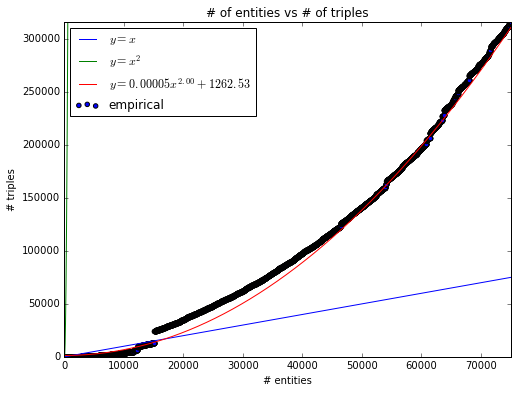

In [14]:
popt, pcov = curve_fit(func, n_entities, n_triples)
fitted_t = func(np.arange(n_e), *popt)
plt.figure(figsize=(8,6))
plt.scatter(n_entities[::100], n_triples[::100], label='empirical')
first_order = [x for x in range(n_e)]
second_order = [x**2 for x in range(n_e)]
plt.plot(first_order, label='$y=x$')
plt.plot(second_order, label='$y=x^2$')
plt.plot(fitted_t, label='$y=%.5f x^{%.2f} + %.2f$' % (popt[2], popt[0], popt[1]))

plt.legend(loc='upper left')
plt.xlim([0, np.max(n_entities)])
plt.ylim([0, np.max(n_triples)+100])
plt.title('# of entities vs # of triples')
plt.xlabel('# entities')
plt.ylabel('# triples')

## Growth rate of triples w.r.t. the number of relations in Freebase

In [15]:
n_relations, n_triples = random_relation_triple(T, n_samples = 10000)

Elpased time 0.319716215133667


(0, 12)

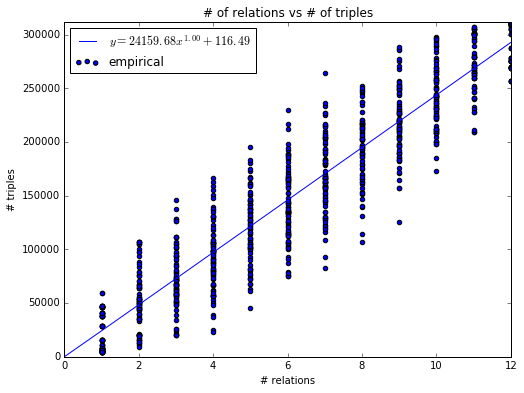

In [16]:
popt, pcov = curve_fit(func, n_relations, n_triples)
fitted_t = func(np.arange(n_r), *popt) 

plt.figure(figsize=(8,6))
plt.scatter(n_relations[::10], n_triples[::10], label='empirical')
plt.title('# of relations vs # of triples')
plt.xlabel('# relations')
plt.ylabel('# triples')

plt.plot(fitted_t, label='$y=%.2f x^{%.2f} + %.2f$' % (popt[2], popt[0], popt[1]))
plt.legend(loc='upper left')
plt.ylim([0, np.max(n_triples)+100])
plt.xlim([0, np.max(n_relations)])

## Number of entities of degree one in Freebase

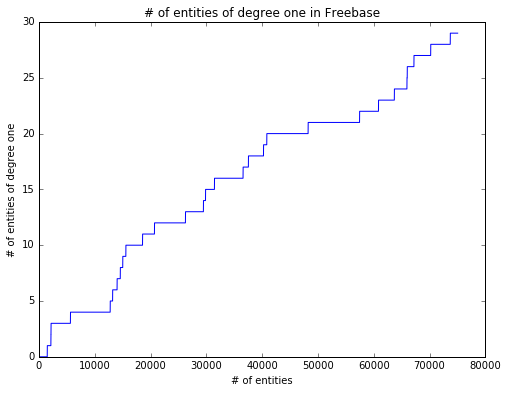

In [17]:
collapsedT = csc_matrix(T[0])
for r in range(1, n_r):
    collapsedT += T[r]

entity_degree = (collapsedT.sum(0) + collapsedT.sum(1).T).tolist()[0]

e_list = np.arange(n_e)
np.random.shuffle(e_list)
one_entity = [entity_degree[ei] == 1 for ei in e_list]
cumsum = np.cumsum(one_entity)        

plt.figure(figsize=(8,6))
plt.plot(cumsum) 
plt.xlabel('# of entities')
plt.ylabel('# of entities of degree one')
plt.title('# of entities of degree one in Freebase')